### CITS5508 labsheet 5

**Author: Hanlin Zhang**<br>
**Date: May 2022**

# Python dodule

In [34]:
from data_loader import DataLoader
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import json
import os
from tensorflow import keras
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import *
import numpy as np
import time

## Load data

In [35]:
# According to the CIFAR-10 website, the training set is split into five batches
# stored in fives files. Each colour image has dimensions equal to 32 x 32 x 3. There
# are 10 classes.
image_width, image_height, image_Nchannels = 32, 32, 3
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# The default values of all the arguments of the load_batch function have been
# set for the CIFAR-10 dataset.
X_train, y_train = DataLoader.load_batch('data_batch')
X_test, y_test = DataLoader.load_batch('test_batch', Nbatches=1)

## Data pre-processing

### Use an 85/15 random split on the training set to form a validation set

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=5508)

# check the split works fine
if len(X_train)/len(X_val) == 85/15:
    print("percent is correct")
else:
    print("percent is incorrect")

percent is correct


The train data set split into two parts with 85/15 ratio into new train data set and validation data set using the specific seed.

In [37]:
tf.random.set_seed(5508)

Here set the seed for the later part which which using tensorflow stuff.

## Display 20 randomly sampled images from the arguments

In [38]:
def display_plot(value_x, value_y, pic_index_list, plot_rows, plot_cols):
    '''A function to display the samples images'''
    fig = plt.figure(figsize = (15, 10))
    plot_count = 1
    for index in pic_index_list:
        fig.add_subplot(plot_rows, plot_cols, plot_count)
        plt.imshow(value_x[index], interpolation='none')
        plt.title(class_names[value_y[index]])
        plt.axis('off')
        plot_count+=1


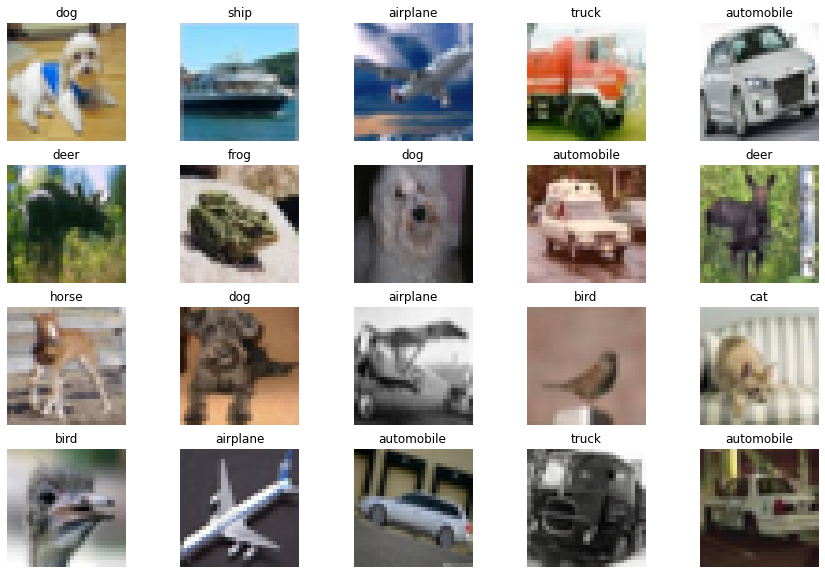

In [39]:
# For train data set
display_plot(X_train, y_train, random.sample(range(len(X_train)), 20), 4, 5)

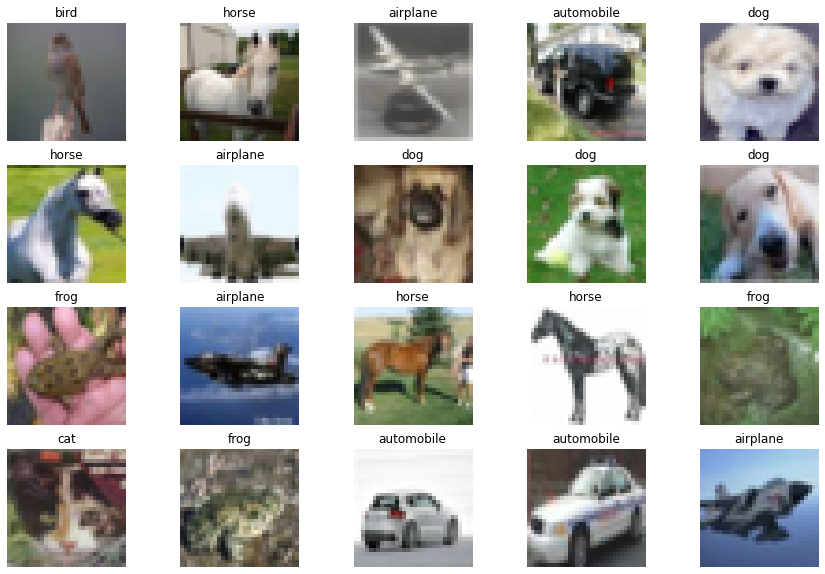

In [40]:
# For test data set
display_plot(X_test, y_test, random.sample(range(len(X_test)), 20), 4, 5)

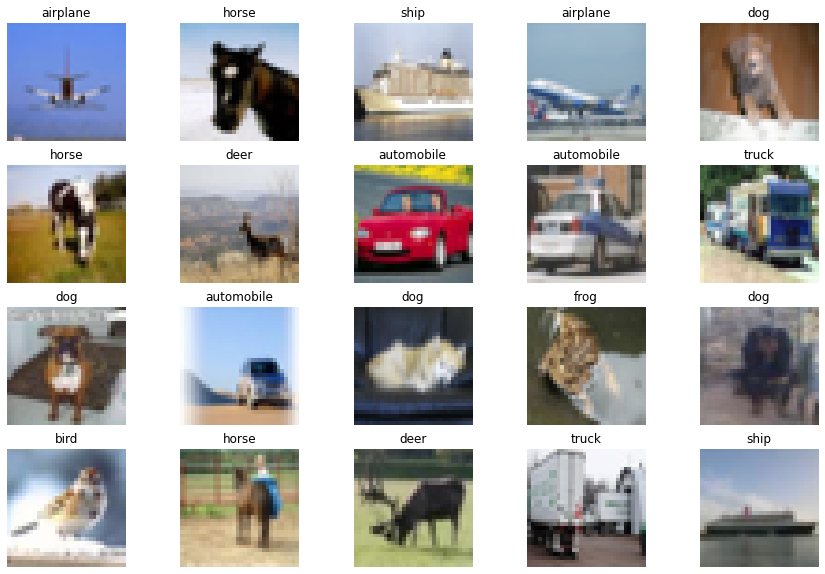

In [41]:
# For validate data set
display_plot(X_val, y_val, random.sample(range(len(X_val)), 20), 4, 5)

## MLP

### creating the model

In [42]:
def create_mlp(kernel_init = 'he_uniform', drop_out_value = 0.2, learning_rate_schedule = 'exponential'):
    '''A function to create the mlp model'''
    model_mlp = keras.models.Sequential([
        keras.layers.Flatten(input_shape = [32, 32, 3]),
        keras.layers.Dropout(rate = drop_out_value),
        keras.layers.Dense(1500, activation = "relu", kernel_initializer = kernel_init),
        keras.layers.Dropout(rate = drop_out_value),
        keras.layers.Dense(1000, activation = "relu", kernel_initializer = kernel_init),
        keras.layers.Dropout(rate = drop_out_value),
        keras.layers.Dense(500, activation = "relu", kernel_initializer = kernel_init),
        keras.layers.Dropout(rate = drop_out_value),
        keras.layers.Dense(10, activation = "softmax")
    ])

    if learning_rate_schedule == 'power':
        optimizer = keras.optimizers.SGD(learning_rate = 0.01, decay = 1e-4)
    elif learning_rate_schedule == 'exponential':
        s = 100 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
        learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
        optimizer = keras.optimizers.SGD(learning_rate)
    model_mlp.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model_mlp

Here we have 3 hidden layers, 1 flatten layer (convert each input image into a 1D array) and 1 output layer, each hidden layer followed by a dropout layer. Two different learning rate schedule show above, power and exponential. A large learning rate might make the model training faster, but it will lead a bigger error, so here I set it a low value.

Dropout is a technique that drops neurons from the neural network or 'ignores' them during training. In other words, different neurons are removed from the newwork on a temporary basis.

The term kernel_initializer is a fancy term for which statistical distribution or function to use for initialising the weights.

A learning rate schedule is a predefined framework that adjusts the learning rate between epochs or iterations as the training progress.

In [43]:
early_stopping = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

A early stop function above. When the loss/accuracy did not decrease/increase much, the model will stop early to reduce the computation cost and time spending.

### Grid Serach for MLP

```
#create model
model = KerasClassifier(build_fn=create_mlp)

#define the grid search parameters
parameter_space = {
    'kernel_init' : ['he_uniform', 'he_normal'],
    'drop_out_value' : [0.2, 0.5],
    'learning_rate_schedule' : ['power', 'exponential']
}

grid = GridSearchCV(estimator=model, param_grid=parameter_space, cv=3)
grid_result = grid.fit(X_train, y_train, epochs = 100, validation_data = (X_val, y_val), callbacks = [early_stopping])
#summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
```

Here we have three hyperparameters: connection weight initialisation, learning rate scheduling and dropout rate able to be adjusted. After using 3-fold cross validation, now we can see the model with the best accuracy is using the hyperparameter: 

Best: 0.510965 using {'drop_out_value': 0.2, 'kernel_init': 'he_uniform', 'learning_rate_schedule': 'exponential'}

### Model with the best hyperparameters

In [44]:
if os.path.exists('Zhang_Hanlin-MLP'):
    #model_mlp = keras.models.model_from_json(json.dumps('Zhang_Hanlin-MLP'))
    model_mlp = tf.keras.models.load_model('Zhang_Hanlin-MLP')
    model_mlp.summary()
    #model_mlp.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
    history_mlp = model_mlp.fit(X_train, y_train, epochs = 1, validation_data = (X_val, y_val), callbacks = [early_stopping])
else:
    print("Can not find the MLP model in current dir!")
    model_mlp = create_mlp(kernel_init = 'he_uniform', drop_out_value = 0.2, learning_rate_schedule = 'exponential')
    model_mlp.summary()
    mlp_start = time.time()
    history_mlp = model_mlp.fit(X_train, y_train, epochs = 100, validation_data = (X_val, y_val), callbacks = [early_stopping])
    mlp_end = time.time()
    model_mlp.save('Zhang_Hanlin-MLP')


Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_51 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dropout_152 (Dropout)        (None, 3072)              0         
_________________________________________________________________
dense_178 (Dense)            (None, 1500)              4609500   
_________________________________________________________________
dropout_153 (Dropout)        (None, 1500)              0         
_________________________________________________________________
dense_179 (Dense)            (None, 1000)              1501000   
_________________________________________________________________
dropout_154 (Dropout)        (None, 1000)              0         
_________________________________________________________________
dense_180 (Dense)            (None, 500)             

In [45]:
model_mlp.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 1.3889 - accuracy: 0.5049


[1.388895034790039, 0.5048999786376953]

The accuracy for the test data set is in [0.4, 0.6], it is not a high value. As we can see, the loss value is high, so it means the model is over-fit.

## CNN

In [46]:
def create_cnn(kernel_size = 3, kernel_number = 128, activation_func = 'relu'):
    '''A function to create the cnn model'''
    model_cnn = keras.models.Sequential([
    keras.layers.Conv2D(64, 8, padding="same", input_shape=[32, 32, 3]),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(activation_func),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(kernel_number, kernel_size, padding="same"),
    #keras.layers.BatchNormalization(),
    keras.layers.Activation(activation_func),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(kernel_number, kernel_size, padding="same"),
    #keras.layers.BatchNormalization(),
    keras.layers.Activation(activation_func),
    keras.layers.Flatten(),
    keras.layers.Dense(kernel_number, kernel_initializer = 'he_uniform'),
    #keras.layers.BatchNormalization(),
    keras.layers.Activation(activation_func),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, kernel_initializer = 'he_uniform'),
    #keras.layers.BatchNormalization(),
    keras.layers.Activation(activation_func),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10),
    keras.layers.Activation("softmax")
    ])


    s = 100 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
    learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
    optimizer = keras.optimizers.SGD(learning_rate)
    model_cnn.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model_cnn

Here we have 3 convolutional layers, 2 pooling layers (between the convolutional layer), 2 fully connected layers, a batch normalisation layer and an output layer. For drop out, learning rate scheduling and kernel_initializer value, keep using the optimal value get from mlp model.

For a better performance of the model, here add in the pooling layers, since they can reduce the sensitivity of the layers.

BN (Batch normalization layer) is helpful to control the numerical values of the network weights. Need to test again and again to see where to place it to gain a better model performance.

Kernel size means the size of a convolutional filter.



### Grid Search for CNN

```
#create model
model = KerasClassifier(build_fn=create_cnn)

#define the grid search parameters
parameter_space = {
    'kernel_size' : [3, 5],
    'kernel_number' : [128, 256],
    'activation_func' : ['relu', 'elu']
}

grid = GridSearchCV(estimator=model, param_grid=parameter_space, cv=3)
grid_result = grid.fit(X_train, y_train, epochs = 100, validation_data = (X_val, y_val), callbacks = [early_stopping])
#summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
```

Here we have three hyperparameters: kernel size, number of kernels and activation function to be adjusted. After using 3-fold cross validation, now we can see the model with the best accuracy is using the hyperparameter: 

Best: 0.708118 using {'activation_func': 'relu', 'kernel_number': 256, 'kernel_size': 3}

In [47]:
if os.path.exists('Zhang_Hanlin-CNN'):
    model_cnn = tf.keras.models.load_model('Zhang_Hanlin-CNN')
    model_cnn.summary()
    history_mlp = model_cnn.fit(X_train, y_train, epochs = 1, validation_data = (X_val, y_val), callbacks = [early_stopping])
else:
    print("Can not find the CNN model in current dir!")
    model_cnn = create_cnn(kernel_size = 3, kernel_number = 256, activation_func = 'relu')
    model_cnn.summary()
    cnn_start = time.time()
    history_mlp = model_cnn.fit(X_train, y_train, epochs = 100, validation_data = (X_val, y_val), callbacks = [early_stopping])
    cnn_end = time.time()
    model_cnn.save('Zhang_Hanlin-CNN')


Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_153 (Conv2D)          (None, 32, 32, 64)        12352     
_________________________________________________________________
batch_normalization_155 (Bat (None, 32, 32, 64)        256       
_________________________________________________________________
activation_306 (Activation)  (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_102 (MaxPoolin (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_154 (Conv2D)          (None, 16, 16, 256)       147712    
_________________________________________________________________
activation_307 (Activation)  (None, 16, 16, 256)       0         
_________________________________________________________________
max_pooling2d_103 (MaxPoolin (None, 8, 8, 256)       

In [48]:
model_cnn.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 1.1072 - accuracy: 0.6425


[1.1071805953979492, 0.6424999833106995]

The accuracy for the test data set is in [0.6, 0.8], it is higher than MLP model. As we can see, the loss value is lower than MLP model.

## Comparing

### Predictions on the training set and the test set

In [49]:
mlp_train_predict = np.argmax(model_mlp.predict(X_train), axis = 1)
mlp_test_predict =np.argmax(model_mlp.predict(X_test), axis = 1)

cnn_train_predict = np.argmax(model_cnn.predict(X_train), axis = 1)
cnn_test_predict =np.argmax(model_cnn.predict(X_test), axis = 1)

### Classification performance

#### Accuracy, F1 score, precision per class

In [50]:
def performance(y_true, y_pred, model_name, data_set_name):
    '''A function to show the model performance'''
    print("Performance of {} based on {} data set".format(model_name, data_set_name))
    print("Accuracy: {}".format(accuracy_score(y_true, y_pred)))
    print("F1 Score: {}".format(f1_score(y_true, y_pred, average='weighted')))
    print("Precision per class: {}".format(precision_score(y_true, y_pred, average=None)))
    print('\n======================================\n')

In [51]:
# Performance of MLP based on train data set
performance(y_train, mlp_train_predict, "MLP", "train")

# Performance of MLP based on test data set
performance(y_test, mlp_test_predict, "MLP", "test")

Performance of MLP based on train data set
Accuracy: 0.5704705882352941
F1 Score: 0.5711832583721701
Precision per class: [0.6911636  0.76137488 0.44080678 0.49026275 0.34858148 0.62627551
 0.52448409 0.69511541 0.6917747  0.78982374]


Performance of MLP based on test data set
Accuracy: 0.5049
F1 Score: 0.5044163399593897
Precision per class: [0.62903226 0.69469027 0.37980769 0.41234222 0.30970149 0.52470187
 0.47898551 0.62180974 0.62062615 0.67201166]




In [52]:
# Performance of CNN based on train data set
performance(y_train, cnn_train_predict, "CNN", "train")

# Performance of CNN based on test data set
performance(y_test, cnn_test_predict, "CNN", "test")

Performance of CNN based on train data set
Accuracy: 0.7418117647058824
F1 Score: 0.7456601289049394
Precision per class: [0.89408941 0.9773639  0.92525773 0.72052904 0.40702948 0.74371612
 0.87214869 0.77283177 0.89088785 0.84734254]


Performance of CNN based on test data set
Accuracy: 0.6425
F1 Score: 0.6432751758297651
Precision per class: [0.81877445 0.91416894 0.83333333 0.52825553 0.35346284 0.59548255
 0.77935943 0.6779661  0.81782178 0.73972603]




In [53]:
# print the difference between CNN model and MLP model
print(precision_score(y_test, cnn_test_predict, average=None) - precision_score(y_test, mlp_test_predict, average=None))

[0.18974219 0.21947867 0.45352564 0.11591331 0.04376135 0.07078067
 0.30037392 0.05615636 0.19719563 0.06771437]


As we can see, for the precision per class, CNN model is much higher than MLP model based on the test data set.

A model will obtain a medium F1 score if one of Precision and Recall is low and the other is high, so both precision and recall for CNN model is larger than MLP model. It means for this side, the CNN model is better than MLP model.

For cat, deer and dog category, both models all not performance well on them.

### Confusion matrix

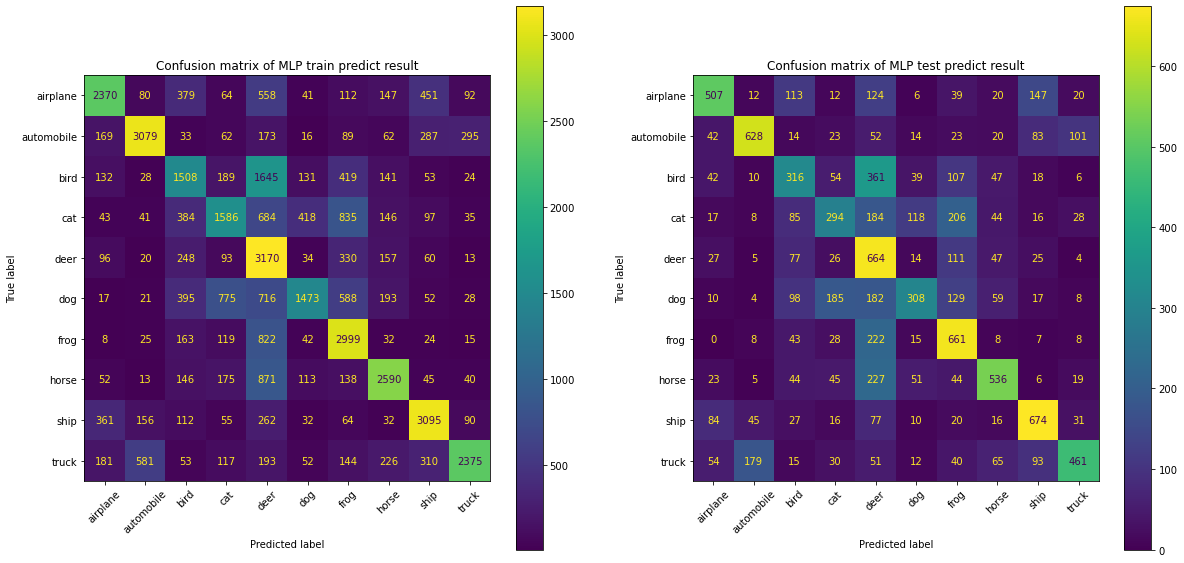

In [54]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, mlp_train_predict)).plot(ax = ax[0])
ax[0].set_title('Confusion matrix of MLP train predict result')
ax[0].set_xticklabels(class_names, rotation=45)
ax[0].set_yticklabels(class_names)

ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, mlp_test_predict)).plot(ax = ax[1])
ax[1].set_title('Confusion matrix of MLP test predict result')
ax[1].set_xticklabels(class_names, rotation=45)
ax[1].set_yticklabels(class_names)


plt.show()


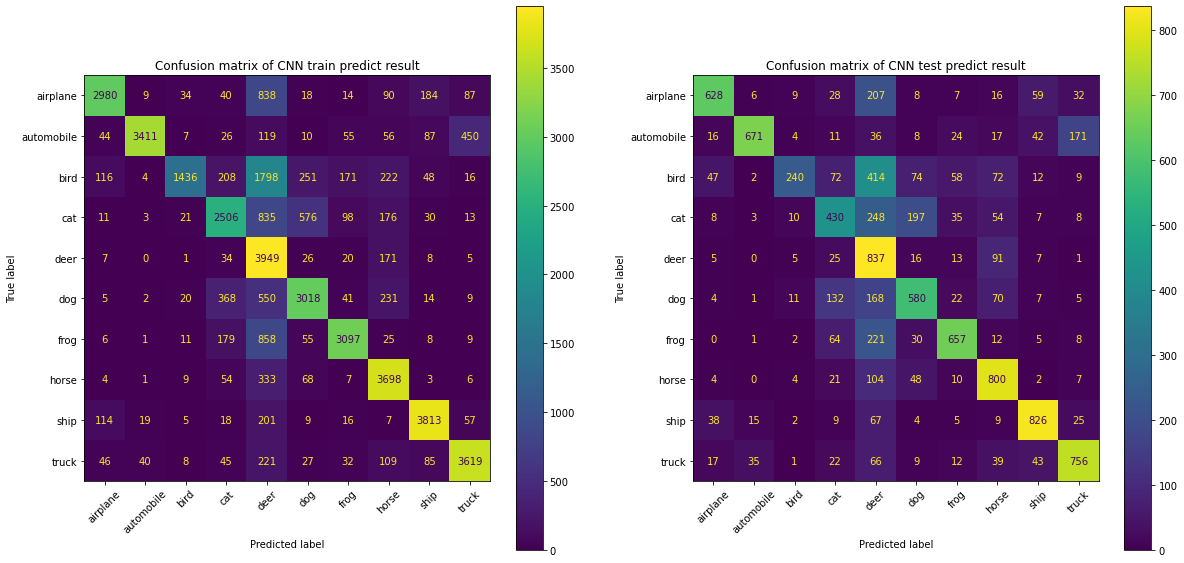

In [55]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, cnn_train_predict)).plot(ax = ax[0])
ax[0].set_title('Confusion matrix of CNN train predict result')
ax[0].set_xticklabels(class_names, rotation=45)
ax[0].set_yticklabels(class_names)


ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, cnn_test_predict)).plot(ax = ax[1])
ax[1].set_title('Confusion matrix of CNN test predict result')
ax[1].set_xticklabels(class_names, rotation=45)
ax[1].set_yticklabels(class_names)

plt.show()

Comapre between the confusion matrix for MLP and CNN model based on test data set, we can see for the same true label, CNN model has higher number in the correct predict label block, so it means CNN model perform better than MLP model.

More clearly, for instance, cat pics are easily to be predict as dog and frog category in both MLP and CNN model.

### Model complexity

In [56]:
try:
    print("time spending for training MLP model is: {} seconds".format(round(mlp_end - mlp_start, 2)))
except:
    print("time spending for training MLP model is: 195.92 seconds")

time spending for training MLP model is: 195.92 seconds


In [57]:
try:
    print("time spending for training CNN model is: {} seconds".format(round(cnn_end - cnn_start, 2)))
except:
    print("time spending for training CNN model is: 81.11 seconds")

time spending for training CNN model is: 81.11 seconds


By comparing the model complexity, the CNN model has less training time than the MLP model.

Here I am facing a problem, if I tried to compute the time spending at the same time when I trained the models, once when I use the exists models to fit on test data set, it won't show the time spending on training model. So, here I record the time spending that I final time to train the models.

## A few correctly classified images and failure cases for the test set

In [58]:
def display(x_true, y_true, y_pred, rows, cols, plot_true_or_false):
    '''A function to display correct pics and failure pics'''
    correct_pic = []
    fail_pic = []

    for each in range(len(y_true)):
        if y_true[each] == y_pred[each]:
            correct_pic.append(each)
        else:
            fail_pic.append(each)
    if plot_true_or_false == True:
        display_plot(x_true, y_pred, random.sample(correct_pic, rows * cols), rows, cols)
    else:
        display_plot(x_true, y_pred, random.sample(fail_pic, rows * cols), rows, cols)
    


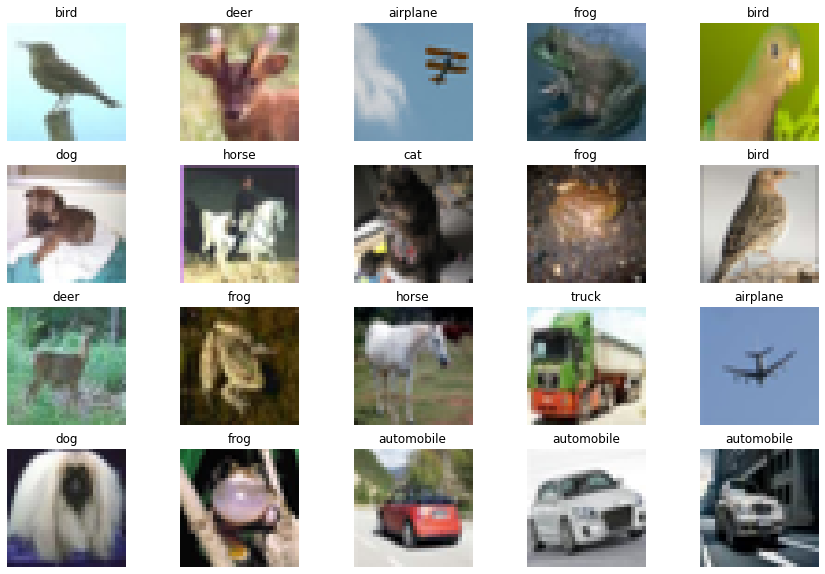

In [59]:
display(X_test, y_test, mlp_test_predict, 4, 5, True)

Above are 20 pics correct predict pictures for mlp model.

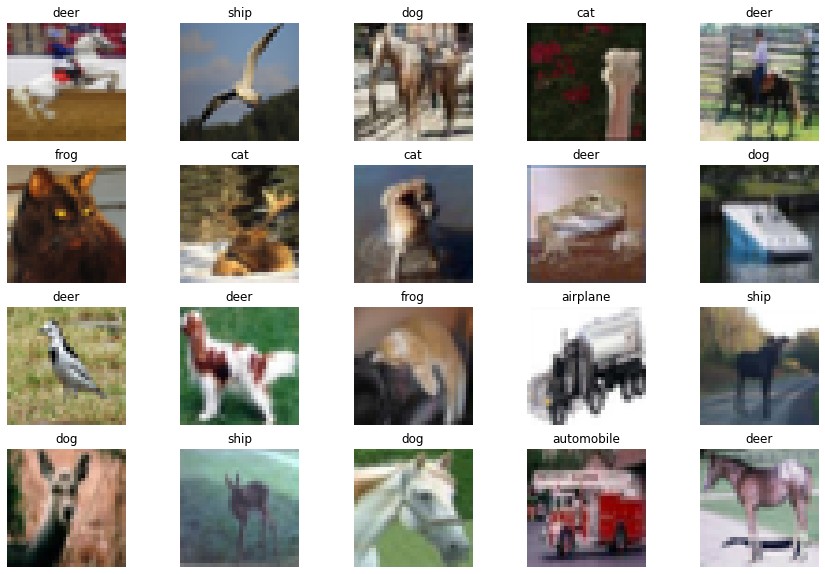

In [60]:
display(X_test, y_test, mlp_test_predict, 4, 5, False)

Above are 20 pics failure predict pictures for mlp model.

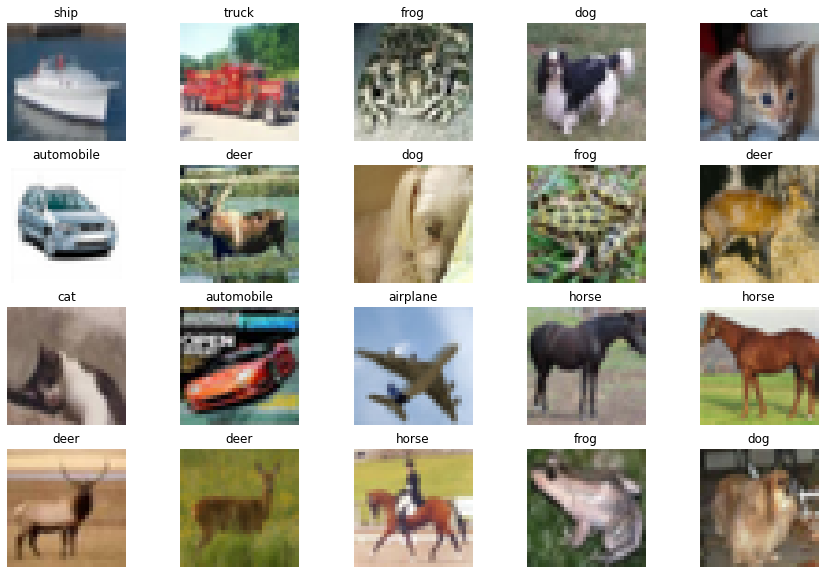

In [61]:
display(X_test, y_test, cnn_test_predict, 4, 5, True)

Above are 20 pics corect predict pictures for cnn model.

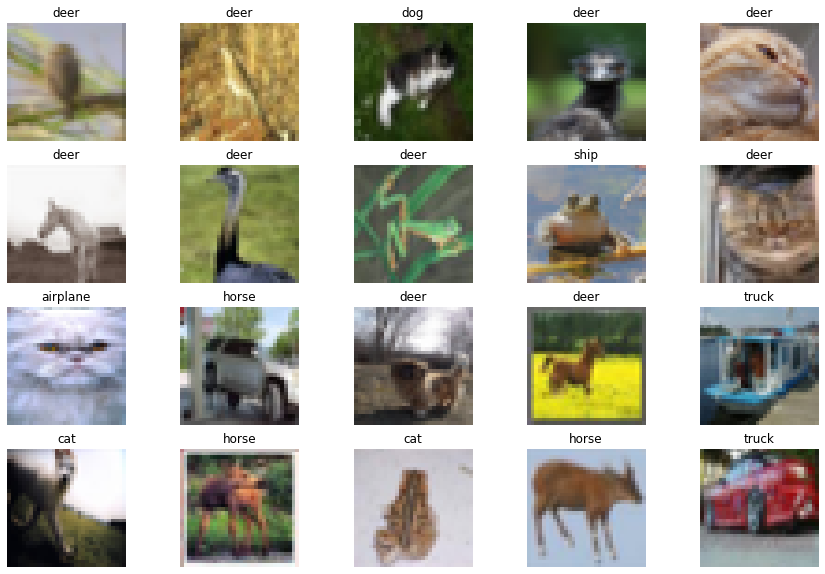

In [62]:
display(X_test, y_test, cnn_test_predict, 4, 5, False)

Above are 20 pics failure predict pictures for cnn model.

## Conclusion

In general, the reason why MLP and CNN not performance well might be (just guessing):

    - The definition of the pics is not high
    - Have no much samples for training

But with the current result I have, CNN model performance better than MLP model. Here is some opinions:

-   Whatever for F1 score, precision, accuracy etc, CNN perform better than MLP

-   Time spending for training data set, CNN is faster than MLP, since the number of weights is dependent on the kernel size instead of the input size which is really important for images.

-   From the side of model complexity, CNN has more hyperparameters able to adjust (except three from MLP, we stil get another three hyperparameters for CNN), so this means CNN is more complex than MLP. 
    <br>So, it is why MLP performance not good and CNN performance better.

-   With the help of the more neurons and more layers, the model will be more complexity, so CNN performance better.

-   Compared between the confusion matrix result, it is easy to find CNN model has more true positive values than MLP model.

-   MLP use one perceptron for each input, and the amout of weights rapidly becomes unmanageable for large images. It will get a dense web which get redundancy and inefficiency.

-   Spatial information will lost when the images is flattened (matrix => vector) into an MLP.

-   In CNN model, we have pool layers and BN layer which can help model avoid over-fitting.